Import data from google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import string 
import pandas as pd
import numpy as np 
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
df = pd.read_csv('/content/drive/Shareddrives/ECE219_P1/Project1-Classification.csv') # Shareddrives, not SharedDrives
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


# **Question 1**

---


### **Overview**

the number of samples in the dataset is **3150**

the number of features in the dataset is **8**

In [ ]:
# Overview
rows_num = len(df.axes[0]) # samples
cols_num = len(df.axes[1]) # features
print("rows num:", rows_num, "|", "cols num:", cols_num)

rows num: 3150 | cols num: 8


###**Histograms**

#### __question_a__ : The total number of alpha-numeric characters per data point (row) in the feature full text

In [ ]:
# Count the # of characters
def count_chars(text): 
  """
  >>> count_chars('a b c d 1 2 ') == 6
  True
  """
  return len(text)

In [ ]:
clean_text = df['full_text'].replace('[^a-zA-Z0-9]', '', regex = True) # Replace non-alpha-numeric characters with ''
num_char = clean_text.map(count_chars) # Return a characters count series
df['count'] = num_char # Insert ...
df['count'].describe()

count     3150.000000
mean      2681.524127
std       3312.793592
min         39.000000
25%       1027.500000
50%       2090.000000
75%       3447.000000
max      80321.000000
Name: count, dtype: float64

In [ ]:
# Using plotly
fig1 = px.histogram(df, x = "count")
fig1.update_layout(yaxis_title = "frequency")
fig1.show()

From this plot, we can find that the character counts of most texts (data points) are less than 10000 alpha-numeric characters.

In [ ]:
# # Alternative: using Seaborn
# hist = sns.histplot(data = df, x = 'count', kde = True, bins = 40);
# hist.set(xlabel = 'char_count', ylabel = 'frequency');

#### __question b__ : The column leaf label – class on the x-axis;

In [ ]:
fig2 = px.histogram(df, x = "leaf_label")
fig2.show()

All leaf classes have the same number of samples (the data points are evenly distributed in leaf classes).

#### __question_c__ : The column root label – class on the x-axis.

In [ ]:
fig3 = px.histogram(df, x = "root_label")
fig3.show()

The number of texts labeled as sports is more than the number of texts labeled as climate (more data points belong to the sports class than the climate class).

# **Binary Classification**




In [ ]:
import numpy as np
import random

np.random.seed(42)
random.seed(42)
print('random seed completed!')

random seed completed!


#### 1. Splitting the entire data

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text", "leaf_label", "root_label","keywords"]], 
                               test_size = 0.2,
                               shuffle = True)

# QUESTION 2: Report the number of training and testing samples.


In [ ]:
print(f'Training set has {train.shape[0]} data samples.')
print(f'Testing set has {test.shape[0]} data samples.')

Training set has 2520 data samples.
Testing set has 630 data samples.


#### 2. Feature Extraction

In [ ]:
# Full_text preprocessing
import re
def clean(text):
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        texter = re.sub(r"<br />", " ", text)
        texter = re.sub(r"&quot;", "\"",texter)
        texter = re.sub('&#39;', "\"", texter)
        texter = re.sub('\n', " ", texter)
        texter = re.sub(' u '," you ", texter)
        texter = re.sub('`',"", texter)
        texter = re.sub(' +', ' ', texter)
        texter = re.sub(r"(!)\1+", r"!", texter)
        texter = re.sub(r"(\?)\1+", r"?", texter)
        texter = re.sub('&amp;', 'and', texter)
        texter = re.sub('\r', ' ',texter)
        clean = re.compile('<.*?>')
        texter = texter.encode('ascii', 'ignore').decode('ascii')
        texter = re.sub(clean, '', texter)
        if texter == "":
            texter = ""
        return texter

In [ ]:
# clean("00 00 adsofhis 00 00 123 dasofha -1231234 aofho 123 -123 dashfo -2.9283 as123 981asd 123 123")

In [ ]:
train = train.applymap(clean)
test = test.applymap(clean)

In [ ]:
# Using the CountVectorizer to convert the collection of text documents to a 
# document-term matrix. Use the “english” stopwords of the CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
count_vect = CountVectorizer(stop_words = 'english', min_df = 3) 
X_train_counts = count_vect.fit_transform(train['full_text']) # Learn the vocabulary dictionary and return document-term matrix.
print(X_train_counts.toarray()[:10])

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
X_train_counts.toarray().shape

(2520, 17922)

In [ ]:
count_vect.get_feature_names_out()

array(['00', '000', '000th', ..., 'zucker', 'zurich', 'zvi'], dtype=object)

In [ ]:
# Tranform the testing set as well
X_test_counts = count_vect.transform(test['full_text'])
display(test['full_text'].shape)
X_test_counts.shape

(630,)

(630, 17922)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape, X_test_tfidf.shape)

(2520, 17922) (630, 17922)


[Text Lemmatization and Stemming](https://www.fireblazeaischool.in/blogs/coding-the-nlp-pipeline-in-python/)

In [ ]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
stop_words = ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')

In [ ]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('JJ'):
        return wordnet.ADJ
    elif nltk_tag.startswith('VB'):
        return wordnet.VERB
    elif nltk_tag.startswith('NN'):
        return wordnet.NOUN
    elif nltk_tag.startswith('RB'):
        return wordnet.ADV
    else:
        return None

In [ ]:
# input: given a sentence; output: gives us a lemmatized sentence
# 'I am loving it' -> 'I be love it'
def lemmatize_sent(sentence):
    for i in string.punctuation:
      sentence = sentence.replace(i,'')
    sentence = sentence.lower()
    tokenized_sentence = nltk.word_tokenize(sentence)
    nltk_tagged = nltk.pos_tag(tokenized_sentence)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), 
                         nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
      # word = word.lower()
      if word not in stop_words and word not in stop_words_en and not word.isdigit():
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
def stemmer_sent(sentence):
  for i in string.punctuation:
    sentence = sentence.replace(i, '')
  sentence = sentence.lower()
  tokenized_sentence = nltk.word_tokenize(sentence)
  nltk_tagged = nltk.pos_tag(tokenized_sentence)
  wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), 
                         nltk_tagged)
  stemmer_sentence = []
  for word, tag in wordnet_tagged:
    # word = word.lower()
    if word not in stop_words and word not in stop_words_en and not word.isdigit():
      if tag is None:
          stemmer_sentence.append(word)
      else:
          stemmer_sentence.append(stemmer.stem(word, tag))
  return " ".join(stemmer_sentence)

In [ ]:
train_dataset_lemmatized = train.applymap(lemmatize_sent)
test_dataset_lemmatized = test.applymap(lemmatize_sent)

In [ ]:
train_dataset_stemmed = train.applymap(stemmer_sent)
test_dataset_stemmed = test.applymap(stemmer_sent)

If the following cell reports "resources_not_found" errors, uncomment the cell above and run it.

In [ ]:
lem_count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
lem_X_train_counts = lem_count_vect.fit_transform(train_dataset_lemmatized['full_text']) # count_vect ? lem_count_vect
lem_X_test_counts = lem_count_vect.transform(test_dataset_lemmatized['full_text'])
print('previous shape (training dataset): ', X_train_counts.shape, 
      '\n', 'current shape: ', lem_X_train_counts.shape,
      'previous shape (testing dataset): ', X_test_counts.shape, 
      '\n', 'current shape: ', lem_X_test_counts.shape)


previous shape (training dataset):  (2520, 17922) 
 current shape:  (2520, 14414) previous shape (testing dataset):  (630, 17922) 
 current shape:  (630, 14414)


In [ ]:
## TF-IDF
tfidf_transformer = TfidfTransformer()
tfid_X_train_counts = tfidf_transformer.fit_transform(lem_X_train_counts)
tfid_X_test_counts = tfidf_transformer.transform(lem_X_test_counts)

print('current shape (training): ', tfid_X_train_counts.shape,
      'current shape (testing): ', tfid_X_test_counts.shape)

current shape (training):  (2520, 14414) current shape (testing):  (630, 14414)


In [ ]:
# stem_tfid_vect = TfidfVectorizer(stop_words = 'english', min_df = 3,
#                                 max_df = 0.7)
# tfid_X_train_counts_stem = stem_tfid_vect.fit_transform(train_dataset_stemmed['full_text'])
# tfid_X_test_counts_stem = stem_tfid_vect.transform(test_dataset_stemmed['full_text'])
stemm_count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
stemm_X_train_counts = stemm_count_vect.fit_transform(train_dataset_stemmed['full_text']) 
stemm_X_test_counts = stemm_count_vect.transform(test_dataset_stemmed['full_text'])
print('previous shape (training dataset): ', X_train_counts.shape, 
      '\n', 'current shape: ', stemm_X_train_counts.shape,
      'previous shape (testing dataset): ', X_test_counts.shape, 
      '\n', 'current shape: ', stemm_X_test_counts.shape)


previous shape (training dataset):  (2520, 17922) 
 current shape:  (2520, 12560) previous shape (testing dataset):  (630, 17922) 
 current shape:  (630, 12560)


In [ ]:
tfidf_transformer = TfidfTransformer()
tfid_X_train_counts_stemm = tfidf_transformer.fit_transform(stemm_X_train_counts)
tfid_X_test_counts_stemm = tfidf_transformer.transform(stemm_X_test_counts)

print('current shape (training): ', tfid_X_train_counts_stemm.shape,
      'current shape (testing): ', tfid_X_test_counts_stemm.shape)

current shape (training):  (2520, 12560) current shape (testing):  (630, 12560)


# Question 4 

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd

In [ ]:
# variables used for this sector
k_arr = [1, 10, 50, 100, 200, 500, 1000, 2000]# k stands for the total number of topics
component = 50 # for k = 50

In [ ]:
# LSI model(mean and variance) training
LSI = TruncatedSVD(n_components= component, random_state=42)
train_LSI = LSI.fit_transform(tfid_X_train_counts)
test_LSI = LSI.transform(tfid_X_test_counts) # should be transform rather than fit, because otherwise there will be error in the step of predicting
U, s, Vh = randomized_svd(tfid_X_train_counts, n_components=component, random_state=42)


In [ ]:
# NMF model training
NMF_model = NMF(n_components= component, init='random', random_state=42)
train_NMF = NMF_model.fit_transform(tfid_X_train_counts)
# test_NMF = NMF_model.fit(tfid_X_test_counts)
H = NMF_model.components_

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



Text(0, 0.5, 'Cumulative Expected Variance Ratio')

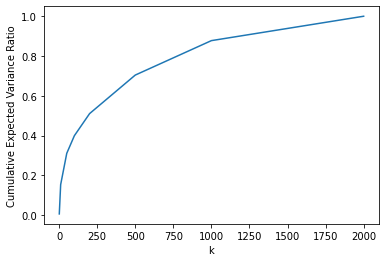

In [ ]:
cum_sum_exp_var_ratio = []
for i in range(len(k_arr)):
  LSI_temp = TruncatedSVD(n_components= k_arr[i], random_state=42)
  LSI_temp.fit_transform(tfid_X_train_counts)
  exp_var_rat_temp = LSI_temp.explained_variance_ratio_
  cum_sum_exp_var_ratio.append(np.sum(exp_var_rat_temp))
plt.plot(k_arr, cum_sum_exp_var_ratio)
plt.xlabel("k")
plt.ylabel("Cumulative Expected Variance Ratio")  

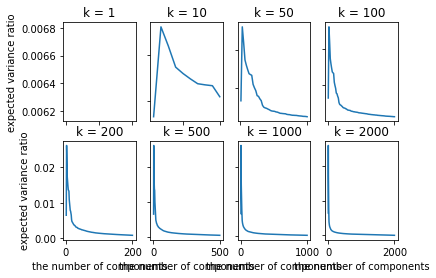

In [ ]:
fig, axs = plt.subplots(2, 4)
for i in range(len(k_arr)):
  LSI_temp = TruncatedSVD(n_components= k_arr[i], random_state=42)
  LSI_temp.fit_transform(tfid_X_train_counts)
  exp_var_rat_temp = LSI_temp.explained_variance_ratio_
  axs[i//4, i%4].plot(range(1, k_arr[i]+1, 1), exp_var_rat_temp)
  axs[i//4, i%4].set_title("k = " + str(k_arr[i]))
for ax in axs.flat:
  ax.set(xlabel="the number of components", ylabel="expected variance ratio")
for ax in axs.flat:
  ax.label_outer()

In [ ]:
# With k = 50 , calculate the reconstruction residual MSE error
  #LSI error
Sig = np.diag(s)
LSI_error = np.sum(np.array(tfid_X_train_counts - U.dot(Sig).dot(Vh))**2)
print("LSI error is: ", LSI_error)
  #NMD error
pred = train_NMF.dot(H)
NMF_error = np.sum(np.array(tfid_X_train_counts - train_NMF.dot(H))**2)
print("NMF error is: ", NMF_error)

LSI error is:  1680.2758805085907
NMF error is:  1705.622099924216


# **Question 5**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV


In [ ]:
# list of binary label
y_test_binary = []

for i in test['root_label']:
  if(i == "climate"):
    y_test_binary.append(0)
  else:
    y_test_binary.append(1)

y_train_binary = []

for i in train['root_label']:
  if(i == "climate"):
    y_train_binary.append(0)
  else:
    y_train_binary.append(1)

In [ ]:
# get the confusion matrix, accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set
def get_stats(label, pred_label):
    print("confusion matrix \n", confusion_matrix(label, pred_label))
    print("accuracy score: ", accuracy_score(label, pred_label))
    print("recall score: ", recall_score(label, pred_label, average="weighted"))
    print("precision score: ", precision_score(label, pred_label, average="weighted"))
    print("f1 score: ", f1_score(label, pred_label, average="weighted"))
    print("-"*40)

# plot the receiver operating characteristic (ROC) curve
def plot_roc(label, decision_function):
    fpr, tpr, thresholds = roc_curve(label, decision_function, pos_label = 1)
    fig, ax = plt.subplots()
    roc_auc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    ax.grid(color='0.7', linestyle='--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.legend(loc="lower right")
    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
    plt.show()



In [ ]:
# Create hard and soft SVM models
hard_SVM = LinearSVC(C=1000,random_state=42,max_iter=100000)
soft_SVM = LinearSVC(C=0.0001,random_state=42,max_iter=100000)
hh_SVM = LinearSVC(C=100000,random_state=42,max_iter=200000)

# extract label for each data point in the training set
y_train = train['root_label']
y_test = test['root_label']
# y_test.head()

# train SVM soft model
hard_svm_model = hard_SVM.fit(train_LSI,y_train_binary)
hard_y_pred = hard_svm_model.predict(test_LSI)
# y_pred_soft = soft_SVM.fit(train_LSI,y_train).predict(test_LSI)

# train SVM hard model
soft_svm_model = soft_SVM.fit(train_LSI,y_train_binary)
soft_y_pred = soft_svm_model.predict(test_LSI)

# train SVM hh model
hh_SVM_model = hh_SVM.fit(train_LSI,y_train_binary)
hh_y_pred = hh_SVM_model.predict(test_LSI)

#get the confusion matrix, accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set
print("hard SVM(gamma = 1000) stats: ")
get_stats(y_test_binary,hard_y_pred)
print("soft SVM(gamma = 0.0001) stats: ")
get_stats(y_test_binary,soft_y_pred)
print("hh SVM stats(gamma = 100000): ")
get_stats(y_test_binary,hh_y_pred)

hard SVM(gamma = 1000) stats: 
confusion matrix 
 [[257   6]
 [ 18 349]]
accuracy score:  0.9619047619047619
recall score:  0.9619047619047619
precision score:  0.962829583561978
f1 score:  0.9620130349352152
----------------------------------------
soft SVM(gamma = 0.0001) stats: 
confusion matrix 
 [[  0 263]
 [  0 367]]
accuracy score:  0.5825396825396826
recall score:  0.5825396825396826
precision score:  0.33935248173343413
f1 score:  0.4288707392017322
----------------------------------------
hh SVM stats(gamma = 100000): 
confusion matrix 
 [[254   9]
 [ 13 354]]
accuracy score:  0.9650793650793651
recall score:  0.9650793650793651
precision score:  0.9652310841279175
f1 score:  0.9651154680878123
----------------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



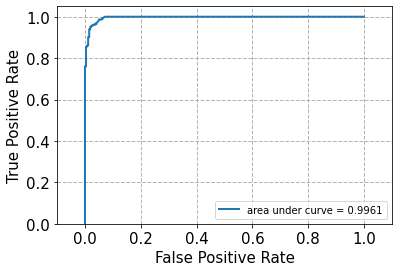

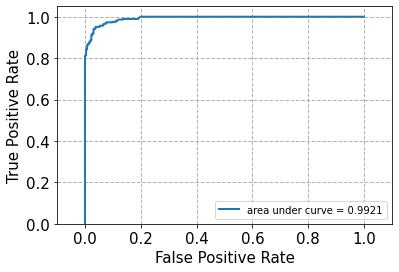

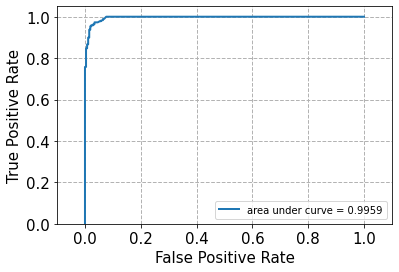

In [ ]:
# plot ROC curve
# print(y_test_binary)
plot_roc(y_test_binary, hard_SVM.decision_function(test_LSI))
plot_roc(y_test_binary, soft_SVM.decision_function(test_LSI))
plot_roc(y_test_binary, hh_SVM.decision_function(test_LSI))

# print(y_test)
# print(hard_SVM.decision_function(test_LSI))

In [ ]:
#cross validation
#get gamma
gamma =[10**i for i in range(-3,7)]
SVM_cv = GridSearchCV(estimator = LinearSVC(random_state=42, loss='hinge', max_iter=100000), 
                      param_grid={'C':gamma}, cv=5)
SVM_cv.fit(train_LSI, y_train_binary)
print(SVM_cv)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarni

GridSearchCV(cv=5,
             estimator=LinearSVC(loss='hinge', max_iter=100000,
                                 random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                               100000, 1000000]})


[0.54880952 0.55198413 0.93373016 0.94404762 0.95039683 0.9547619
 0.95079365 0.94642857 0.94047619 0.94484127]
gamma = 100 has the highest mean test score
confusion matrix 
 [[257   6]
 [ 17 350]]
accuracy score:  0.9634920634920635
recall score:  0.9634920634920635
precision score:  0.9642810928466631
f1 score:  0.9635882580132562
----------------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



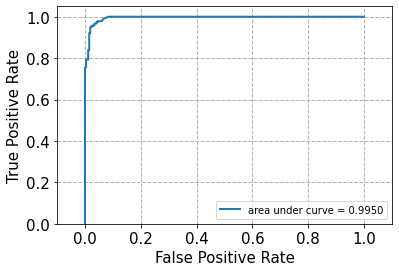

In [ ]:
# obtain the best SVM gamma value
result = SVM_cv.cv_results_
print(result['mean_test_score'])
best_gamma = result['param_C'][np.argmax(result['mean_test_score'])]
print("gamma =", best_gamma, "has the highest mean test score")
print("=" * 40)

#train SVM model with the best gamma
best_SVM = LinearSVC(C = best_gamma, loss='hinge', random_state=42)
best_SVM = best_SVM.fit(train_LSI, y_train_binary)
Best_SVM_label = best_SVM.predict(test_LSI)

# get stats of the best model and plot roc
get_stats(y_test_binary,Best_SVM_label)
plot_roc(y_test_binary, best_SVM.decision_function(test_LSI))


# Question 6

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
k = [10**k for k in range(-5,6)]

confusion matrix 
 [[257   6]
 [ 18 349]]
accuracy score:  0.9619047619047619
recall score:  0.9619047619047619
precision score:  0.962829583561978
f1 score:  0.9620130349352152
----------------------------------------


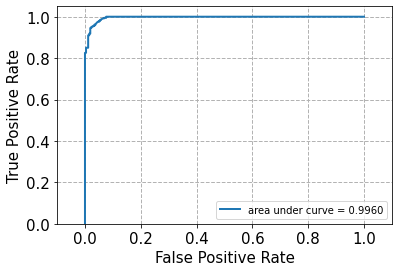

In [ ]:
# logistic regression without regularization (C needs to be large)
lr_noreg = LogisticRegression(random_state=42, penalty = 'none', max_iter=1000)  
y_pred_lr_lr_noreg = lr_noreg.fit(train_LSI, y_train_binary).predict(test_LSI)
get_stats(y_test_binary, y_pred_lr_lr_noreg)
plot_roc(y_test_binary,  lr_noreg.fit(train_LSI, y_train_binary).decision_function(test_LSI))


In [ ]:
# L1 regularization
lr_L1 = GridSearchCV(estimator = LogisticRegression(penalty='l1', 
                                                    solver='liblinear', 
                                                    random_state=42), 
                     param_grid={'C':k}, cv=5)
lr_L1.fit(train_LSI, y_train_binary)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]})

[0.45119048 0.45119048 0.45119048 0.45119048 0.92420635 0.94365079
 0.95039683 0.95       0.94960317 0.94960317 0.94920635]
C = 10 has the highest mean test score
confusion matrix 
 [[257   6]
 [ 17 350]]
accuracy score:  0.9634920634920635
recall score:  0.9634920634920635
precision score:  0.9642810928466631
f1 score:  0.9635882580132562
----------------------------------------


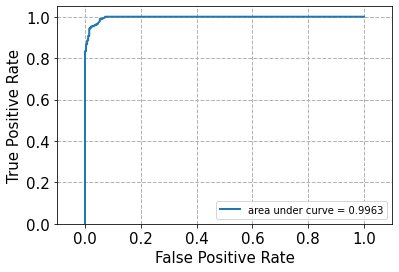

In [ ]:
result_lr_L1 = lr_L1.cv_results_
print(result_lr_L1['mean_test_score'])
best_k_lr_l1 = result_lr_L1['param_C'][np.argmax(result_lr_L1['mean_test_score'])]
print("C =",best_k_lr_l1, "has the highest mean test score")
print("=" * 40)

#train LogisticRegression model with the best gamma
best_lr_l1 = LogisticRegression(penalty="l1", solver='liblinear',
                                C = best_k_lr_l1, random_state=42)
best_lr_l1.fit(train_LSI, y_train_binary)
best_lr_l1_label = best_lr_l1.predict(test_LSI)

# get stats of the best model and plot roc
get_stats(y_test_binary,best_lr_l1_label)
plot_roc(y_test_binary, best_lr_l1.decision_function(test_LSI))

In [ ]:
# L2 regularization
lr_L2 = GridSearchCV(estimator = LogisticRegression(penalty='l2', 
                                                    solver='newton-cg', 
                                                    random_state=42),
                     param_grid={'C':k}, cv=5)
lr_L2.fit(train_LSI, y_train_binary)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='newton-cg'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]})

[0.54880952 0.54880952 0.54880952 0.66666667 0.92142857 0.94444444
 0.94960317 0.95238095 0.95277778 0.94960317 0.94920635]
C = 1000 has the highest mean test score
confusion matrix 
 [[257   6]
 [ 18 349]]
accuracy score:  0.9619047619047619
recall score:  0.9619047619047619
precision score:  0.962829583561978
f1 score:  0.9620130349352152
----------------------------------------


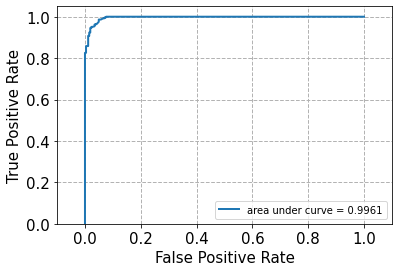

In [ ]:
result_lr_L2 = lr_L2.cv_results_
print(result_lr_L2['mean_test_score'])
best_k_lr_l2 = result_lr_L2['param_C'][np.argmax(result_lr_L2['mean_test_score'])]
print("C =",best_k_lr_l2, "has the highest mean test score")
print("=" * 40)

#train LogisticRegression model with the best gamma
best_lr_l2 = LogisticRegression(penalty="l2", solver='newton-cg', 
                                C = best_k_lr_l2, random_state=42)
best_lr_l2.fit(train_LSI, y_train_binary)
best_lr_l2_label = best_lr_l2.predict(test_LSI)

# get stats of the best model and plot roc
get_stats(y_test_binary,best_lr_l2_label)
plot_roc(y_test_binary, best_lr_l2.decision_function(test_LSI))

# Question 7

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Train a GaussianNB classifie
GNB = GaussianNB().fit(train_LSI, y_train_binary)
GNB_pred = GNB.predict(test_LSI)

confusion matrix 
 [[260   3]
 [ 32 335]]
accuracy score:  0.9444444444444444
recall score:  0.9444444444444444
precision score:  0.9490804535588518
f1 score:  0.9447532639022
----------------------------------------


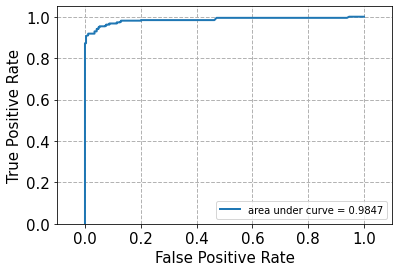

In [ ]:
# get stats of the best model and plot roc
get_stats(y_test_binary,GNB_pred)
plot_roc(y_test_binary, GNB.predict_proba(test_LSI)[:,1])

# Question 8

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# create pipe line
scaler = StandardScaler(with_mean=False)
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english')),
    ('tfidf', TfidfTransformer()),
    ("scaler", scaler), 
    ('reduce_dim', TruncatedSVD()),
    ('clf', GaussianNB()),
]
)

param_grid = [
    {
        'vect__min_df': [3, 5],
        'reduce_dim': [TruncatedSVD(n_components=5, random_state=42),
                       TruncatedSVD(n_components=30, random_state=42),
                       TruncatedSVD(n_components=80, random_state=42),
                       NMF(n_components=5, random_state=42),
                       NMF(n_components=30, random_state=42),
                       NMF(n_components=80, random_state=42)
        ],
        'clf': [LinearSVC(C=best_SVM.C, random_state=42, loss='hinge'),
                LogisticRegression(penalty='l1', solver='liblinear', C=best_lr_l1.C, random_state=42),
                LogisticRegression(penalty='l2', solver='newton-cg', C=best_lr_l2.C, random_state=42),
                GaussianNB()
        ]
    }
]

In [ ]:
# grid1 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = param_grid, scoring='accuracy')
# grid1.fit(train_dataset_lemmatized['full_text'], y_train_binary) 
# result_lemm = pd.DataFrame(grid1.cv_results_)
# result_lemm['lemmatized'] = True
# result_lemm['Stemmed'] = False

In [ ]:
# grid2 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = param_grid, scoring='accuracy')
# grid2.fit(train_dataset_stemmed['full_text'], y_train_binary)
# result_stem = pd.DataFrame(grid2.cv_results_)
# result_stem['lemmatized'] = False
# result_stem['Stemmed'] = True

In [ ]:
# total_results = pd.concat([result_lemm, result_stem])
# total_results = total_results[['mean_test_score', 'param_clf', 'param_reduce_dim','param_vect__min_df',
#                    'lemmatized', 'Stemmed']].sort_values(by=['mean_test_score'], ascending = False)
# total_results = total_results.reset_index(drop=True)                     

In [ ]:
# total_results.head()

# Question 9

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [ ]:
display(train['leaf_label'].value_counts())
test['leaf_label'].value_counts()

earthquake             291
football               289
%22forest%20fire%22    288
drought                282
soccer                 282
chess                  279
flood                  276
cricket                269
hockey                 264
Name: leaf_label, dtype: int64

hockey                 86
cricket                81
flood                  74
chess                  71
drought                68
soccer                 68
%22forest%20fire%22    62
football               61
earthquake             59
Name: leaf_label, dtype: int64

In [ ]:
## Preliminary task: to convert muticlass 'leaf_label' to numbers
def remap(l):
  map_row_to_class = {"chess" : 0, "cricket": 1, "hockey" : 2, "soccer" : 3, "football" : 4, "%22forest%20fire%22" : 5, "flood" : 6, "earthquake" : 7, "drought" : 8}
  new_list = []
  for i in l:
    new_list.append(map_row_to_class[i])
  return new_list

In [ ]:
## X_train stays the same, but we need to change the y_pred& y_test to leaf_node instead
y_train_multi = remap(train['leaf_label'])
y_test_multi = remap(test['leaf_label'])

In [ ]:
## 1) First perform Naive Bayes classifictaion
GNB_model = GaussianNB().fit(train_LSI,y_train_multi)
y_pred_multi = GNB_model.predict(test_LSI)
print("GNB for multi stats: ")
get_stats(y_test_multi,y_pred_multi)

GNB for multi stats: 
confusion matrix 
 [[61  0  2  1  0  1  0  6  0]
 [ 2 74  2  0  0  1  0  2  0]
 [ 1  0 78  2  0  2  0  3  0]
 [ 5  0  6 16 40  0  0  1  0]
 [ 3  0 10 16 30  0  0  2  0]
 [ 2  1  0  0  0 42  7  6  4]
 [ 0  0  1  0  0  3 67  2  1]
 [ 0  0  1  0  0  0  0 56  2]
 [ 0  0  3  0  0  5  6  5 49]]
accuracy score:  0.7507936507936508
recall score:  0.7507936507936508
precision score:  0.7465178780725656
f1 score:  0.7399947073332245
----------------------------------------


In [ ]:
## 2) Then perform One vs One classifictaion
svm_1VS1 = OneVsOneClassifier(LinearSVC(random_state=42, C=10)).fit(train_LSI, y_train_multi)
y_pred_1VS1 = svm_1VS1.predict(test_LSI)
print("One VS One for multi stats: ")
get_stats(y_test_multi,y_pred_1VS1)

One VS One for multi stats: 
confusion matrix 
 [[61  2  1  0  0  5  0  2  0]
 [ 0 75  0  0  2  3  0  1  0]
 [ 1  0 78  2  0  5  0  0  0]
 [ 0  0  0 30 36  2  0  0  0]
 [ 0  0  0 37 23  1  0  0  0]
 [ 0  0  0  0  0 58  1  0  3]
 [ 1  0  0  1  0  7 63  0  2]
 [ 0  0  0  0  0  1  0 56  2]
 [ 0  0  1  0  0 11  1  0 55]]
accuracy score:  0.792063492063492
recall score:  0.792063492063492
precision score:  0.8100751063807898
f1 score:  0.79673431420768
----------------------------------------


In [ ]:
## 3) Perform One vs the rest classifictaion
svm_1VS_all = OneVsRestClassifier(LinearSVC(random_state=42, C=10)).fit(train_LSI, y_train_multi)
y_pred_1VS_all = svm_1VS_all.predict(test_LSI)
print("One VS the rest for multi stats: ")
get_stats(y_test_multi,y_pred_1VS_all)

One VS the rest for multi stats: 
confusion matrix 
 [[64  2  2  0  0  3  0  0  0]
 [ 1 77  0  0  1  1  0  1  0]
 [ 1  0 80  1  0  4  0  0  0]
 [ 2  0  0 30 34  2  0  0  0]
 [ 2  0  1 26 30  1  0  0  1]
 [ 0  0  0  0  0 57  1  0  4]
 [ 0  0  0  1  0  6 64  1  2]
 [ 0  0  0  0  0  1  0 56  2]
 [ 0  0  1  0  0 12  1  0 54]]
accuracy score:  0.8126984126984127
recall score:  0.8126984126984127
precision score:  0.8201970977689629
f1 score:  0.8133638639002908
----------------------------------------


In [ ]:
def advanced_remap(l):
  map_row_to_class = {"chess" : 0, "cricket": 1, "hockey" : 2, "soccer" : 3, "football" : 3, "%22forest%20fire%22" : 5, "flood" : 6, "earthquake" : 7, "drought" : 8}
  new_list = []
  for i in l:
    new_list.append(map_row_to_class[i])
  return new_list

In [ ]:
y_train_multi2 = advanced_remap(train['leaf_label'])
y_test_multi2 = advanced_remap(test['leaf_label'])

In [ ]:
GNB_model2 = GaussianNB().fit(train_LSI,y_train_multi2)
y_pred_multi2 = GNB_model2.predict(test_LSI)
print("GNB for multi stats: ")
get_stats(y_test_multi2,y_pred_multi2)

GNB for multi stats: 
confusion matrix 
 [[ 61   0   2   1   1   0   6   0]
 [  2  74   2   0   1   0   2   0]
 [  1   0  78   2   2   0   3   0]
 [  8   0  16 102   0   0   3   0]
 [  2   1   0   0  42   7   6   4]
 [  0   0   1   0   3  67   2   1]
 [  0   0   1   0   0   0  56   2]
 [  0   0   3   0   5   6   5  49]]
accuracy score:  0.8396825396825397
recall score:  0.8396825396825397
precision score:  0.8545904404308423
f1 score:  0.8406239034786143
----------------------------------------


In [ ]:
svm_1VS12 = OneVsOneClassifier(LinearSVC(random_state=42)).fit(train_LSI, y_train_multi2)
y_pred_1VS12 = svm_1VS12.predict(test_LSI)
print("One VS One for multi stats: ")
get_stats(y_test_multi2,y_pred_1VS12)

One VS One for multi stats: 
confusion matrix 
 [[ 59   2   1   0   8   0   1   0]
 [  0  74   0   2   3   0   1   1]
 [  1   0  79   1   5   0   0   0]
 [  0   0   0 126   3   0   0   0]
 [  0   0   0   0  56   1   1   4]
 [  0   0   0   1   7  64   0   2]
 [  0   0   0   0   1   0  56   2]
 [  0   0   0   0  12   1   0  55]]
accuracy score:  0.9031746031746032
recall score:  0.9031746031746032
precision score:  0.9228306367122157
f1 score:  0.9083062388230142
----------------------------------------


In [ ]:
svm_1VS_rest2 = OneVsRestClassifier(LinearSVC(random_state=42)).fit(train_LSI, y_train_multi2)
y_pred_1VS_rest2 = svm_1VS_rest2.predict(test_LSI)
print("One VS the rest for multi stats: ")
get_stats(y_test_multi2,y_pred_1VS_rest2)

One VS the rest for multi stats: 
confusion matrix 
 [[ 65   2   1   0   3   0   0   0]
 [  1  75   0   3   1   0   1   0]
 [  0   0  80   2   4   0   0   0]
 [  0   0   0 127   2   0   0   0]
 [  2   0   0   0  55   0   0   5]
 [  0   0   0   1   5  65   1   2]
 [  0   0   0   1   1   0  55   2]
 [  0   0   1   0  12   1   0  54]]
accuracy score:  0.9142857142857143
recall score:  0.9142857142857143
precision score:  0.923977854102336
f1 score:  0.9167460922982267
----------------------------------------


In [ ]:
get_stats(y_test_multi,y_pred_1VS_all)

confusion matrix 
 [[64  2  2  0  0  3  0  0  0]
 [ 1 77  0  0  1  1  0  1  0]
 [ 1  0 80  1  0  4  0  0  0]
 [ 2  0  0 30 34  2  0  0  0]
 [ 2  0  1 26 30  1  0  0  1]
 [ 0  0  0  0  0 57  1  0  4]
 [ 0  0  0  1  0  6 64  1  2]
 [ 0  0  0  0  0  1  0 56  2]
 [ 0  0  1  0  0 12  1  0 54]]
accuracy score:  0.8126984126984127
recall score:  0.8126984126984127
precision score:  0.8201970977689629
f1 score:  0.8133638639002908
----------------------------------------


In [ ]:
# 
df_train_wo_sf = train.loc[(train['leaf_label'] != 'soccer') & (train['leaf_label'] != 'football')]
df_train_sf = train.loc[(train['leaf_label'] == 'soccer') | (train['leaf_label'] == 'football')]


df_test_wo_sf = test.loc[(test['leaf_label'] != 'soccer') & (test['leaf_label'] != 'football')]
df_test_sf = test.loc[(test['leaf_label'] == 'soccer') | (test['leaf_label'] == 'football')]

df_train_new_wo_sf = pd.DataFrame(np.repeat(df_train_wo_sf.values,2,axis = 0))
df_train_new_wo_sf.columns = df_train_wo_sf.columns

df_test_new_wo_sf = pd.DataFrame(np.repeat(df_test_wo_sf.values,2,axis = 0))
df_test_new_wo_sf.columns = df_test_wo_sf.columns

df_test_new_wo_sf
# df_test_sf

,full_text,leaf_label,root_label,keywords
0,'By Jared Strong Iowa Capital Dispatch Average...,drought,climate,"['corn', 'capital', 'drought', 'state', 'predi..."
1,'By Jared Strong Iowa Capital Dispatch Average...,drought,climate,"['corn', 'capital', 'drought', 'state', 'predi..."
2,"'Beneath America's High Plains, a significant ...",drought,climate,"['experts', 'texas', 'aquifer', 'state', 'tout..."
3,"'Beneath America's High Plains, a significant ...",drought,climate,"['experts', 'texas', 'aquifer', 'state', 'tout..."
4,"' MISSION, Kan. -- Thousands of flights were c...",flood,climate,"['temperatures', 'storm', 'state', 'central', ..."
...,...,...,...,...
997,'Republican U.S. Rep. Mike Flood is projected ...,flood,climate,"['election', 'state', 'projected', '1st', 'bro..."
998,'Low water levels have caused the district to ...,drought,climate,"['threshold', 'enters', 'drought', 'springsedw..."
999,'Low water levels have caused the district to ...,drought,climate,"['threshold', 'enters', 'drought', 'springsedw..."
1000,'We have used your information to see if you h...,chess,sports,"['verify', 'button', 'used', 'existing', 'purc..."


In [ ]:
df_wo_sf = df.loc[(df['leaf_label'] != 'soccer') & (df['leaf_label'] != 'football')]
df_sf = df.loc[(df['leaf_label'] == 'soccer') | (df['leaf_label'] == 'football')]
df_new_wo_sf = pd.DataFrame(np.repeat(df_wo_sf.values,2,axis = 0))
df_new_wo_sf.columns = df_wo_sf.columns
df_new = pd.concat([df_new_wo_sf, df_sf])

In [ ]:
train_new, test_new = train_test_split(df_new[["full_text", "leaf_label", "root_label","keywords"]], 
                               test_size = 0.2,
                               shuffle = True)

In [ ]:
df_train_new = pd.concat([df_train_new_wo_sf, df_train_sf])
df_test_new = pd.concat([df_test_new_wo_sf, df_test_sf])

In [ ]:
train_new_dataset_lemmatized = df_train_new.applymap(lemmatize_sent)
test_new_dataset_lemmatized = df_test_new.applymap(lemmatize_sent)

In [ ]:
new_lem_count_vect = CountVectorizer(stop_words = 'english', min_df = 3)
new_lem_X_train_counts = new_lem_count_vect.fit_transform(train_new_dataset_lemmatized['full_text']) # count_vect ? lem_count_vect
new_lem_X_test_counts = new_lem_count_vect.transform(test_new_dataset_lemmatized['full_text'])


In [ ]:
## TF-IDF
new_tfidf_transformer = TfidfTransformer()
new_tfid_X_train_counts = new_tfidf_transformer.fit_transform(new_lem_X_train_counts)
new_tfid_X_test_counts = new_tfidf_transformer.transform(new_lem_X_test_counts)

In [ ]:
# LSI model(mean and variance) training
new_LSI = TruncatedSVD(n_components= 500, random_state=42)
new_train_LSI = new_LSI.fit_transform(new_tfid_X_train_counts)
new_test_LSI = new_LSI.transform(new_tfid_X_test_counts)

In [ ]:
y_train_multi3 = advanced_remap(df_train_new['leaf_label'])
y_test_multi3 = advanced_remap(df_test_new['leaf_label'])
# print(new_train_LSI.shape)
new_svm_1VS_rest3 = OneVsRestClassifier(LinearSVC(random_state=42)).fit(new_train_LSI, y_train_multi3)
y_pred_1VS_rest3 = new_svm_1VS_rest3.predict(new_test_LSI)

print("One VS the rest for multi stats: ")
get_stats(y_test_multi3,y_pred_1VS_rest3)


One VS the rest for multi stats: 
confusion matrix 
 [[128   2   2   0   6   0   2   2]
 [  0 156   0   2   2   0   0   2]
 [  0   2 160   2   8   0   0   0]
 [  0   0   0 127   1   0   0   1]
 [  4   0   2   0 112   0   0   6]
 [  0   0   2   2  10 130   0   4]
 [  0   0   0   0   0   0 114   4]
 [  0   0   0   0  18   2   0 116]]
accuracy score:  0.9221927497789567
recall score:  0.9221927497789567
precision score:  0.9298421789029521
f1 score:  0.9241553776367073
----------------------------------------


In [ ]:
df_train_new.head()

,full_text,leaf_label,root_label,keywords
0,"'As of Sunday night, a lopsided area of low pr...",flood,climate,"['system', 'storm', 'pressure', 'type', 'high'..."
1,"'As of Sunday night, a lopsided area of low pr...",flood,climate,"['system', 'storm', 'pressure', 'type', 'high'..."
2,'The U.N. childrens agency says some 2 million...,flood,climate,"['floods', 'missing', 'survivors', 'million', ..."
3,'The U.N. childrens agency says some 2 million...,flood,climate,"['floods', 'missing', 'survivors', 'million', ..."
4,'Wicked winds and heavy rains battered the sta...,flood,climate,"['heavy', 'damage', 'came', 'storm', 'crashing..."


In [ ]:
y_train_multi3[:5]

[6, 6, 6, 6, 6]

In [ ]:
get_stats(y_test_multi2,y_pred_1VS_rest2)

confusion matrix 
 [[ 65   2   1   0   3   0   0   0]
 [  1  75   0   3   1   0   1   0]
 [  0   0  80   2   4   0   0   0]
 [  0   0   0 127   2   0   0   0]
 [  2   0   0   0  55   0   0   5]
 [  0   0   0   1   5  65   1   2]
 [  0   0   0   1   1   0  55   2]
 [  0   0   1   0  12   1   0  54]]
accuracy score:  0.9142857142857143
recall score:  0.9142857142857143
precision score:  0.923977854102336
f1 score:  0.9167460922982267
----------------------------------------


# Question 10

# Question 11

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
k =[50,100,200,300]
def choose_dic(k):
  embeddings_dict = {}
  file = "/content/drive/Shareddrives/ECE219_P1/glove.6B." + str(k) + "d.txt"
  with open(file, 'r') as f: # if 'r' fails with unicode error, please use 'rb'
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector

  return embeddings_dict

def generate_keywords_list(df):
  df_keywords = df['keywords']
  keywords_list = []
  for i in range(len(df_keywords)):
    curr_key_words_list = df_keywords.iloc[i]
    curr_list = curr_key_words_list.replace('\'', '')
    curr_list = curr_list.replace('[', '')
    curr_list = curr_list.replace(']', '')
    curr_list = curr_list.split(', ')
    keywords_list.append(curr_list)
  return keywords_list


def get_glove_vector(k, vocab, embeddings_dict):
  # embeddings_dict = choose_dic(k)
  if(vocab.lower() in (embeddings_dict.keys())):
    return np.array(embeddings_dict[vocab.lower()])
  else:
    #print(vocab)
    return np.zeros(k)

def create_Glove_vec(df,k,embedding_dic):
  glove_vec = np.array([])
  keywords_list = generate_keywords_list(df)
  for i in range(len(keywords_list)):
    cur_vec = np.zeros(k)
    for vocab in keywords_list[i]:
      cur_vec += get_glove_vector(k, vocab,embedding_dic)
    if(i == 0):
      glove_vec = np.array([cur_vec])
    else:
      glove_vec = np.vstack([glove_vec, cur_vec])
  return glove_vec

def get_glove_result_svc(train, test, k, y_train_binary, y_test_binary):
  embedding_dic = choose_dic(k) 

  train_glove = create_Glove_vec(train, k, embedding_dic)
  test_glove = create_Glove_vec(test, k, embedding_dic)
  # normalization
  normalized_train_glove = normalize(train_glove)
  normalized_test_glove = normalize(test_glove)
  # svc
  glove_svc = LinearSVC(C=1000, random_state=42,max_iter=100000)
  glove_svm_model = glove_svc.fit(normalized_train_glove,y_train_binary)
  glove_y_pred = glove_svm_model.predict(normalized_test_glove)
  get_stats(y_test_binary, glove_y_pred)
  plot_roc(y_test_binary, glove_svm_model.decision_function(normalized_test_glove))
  return accuracy_score(y_test_binary, glove_y_pred) 

confusion matrix 
 [[240  23]
 [ 15 352]]
accuracy score:  0.9396825396825397
recall score:  0.9396825396825397
precision score:  0.9397144102085279
f1 score:  0.9395419292993417
----------------------------------------


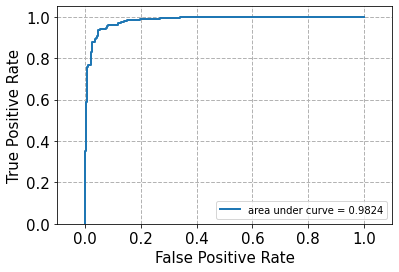

0.9396825396825397

In [ ]:
get_glove_result_svc(train, test, 300, y_train_binary, y_test_binary)


========================= results for 50 dimension =========================
confusion matrix 
 [[250  13]
 [ 15 352]]
accuracy score:  0.9555555555555556
recall score:  0.9555555555555556
precision score:  0.9556221820165992
f1 score:  0.9555790141855715
----------------------------------------


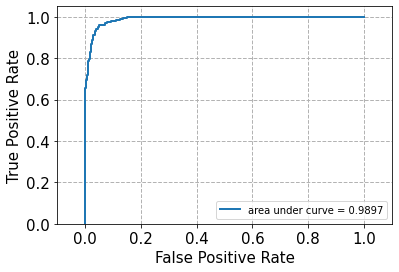

========================= results for 100 dimension =========================
confusion matrix 
 [[248  15]
 [ 12 355]]
accuracy score:  0.9571428571428572
recall score:  0.9571428571428572
precision score:  0.9571161271161271
f1 score:  0.9571071661137583
----------------------------------------


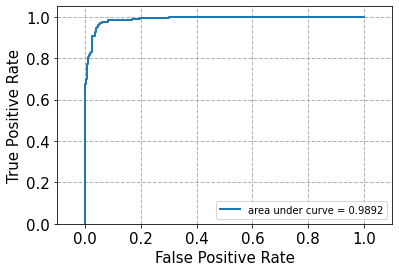

========================= results for 200 dimension =========================
confusion matrix 
 [[239  24]
 [ 15 352]]
accuracy score:  0.9380952380952381
recall score:  0.9380952380952381
precision score:  0.9381634476541497
f1 score:  0.9379313431144707
----------------------------------------


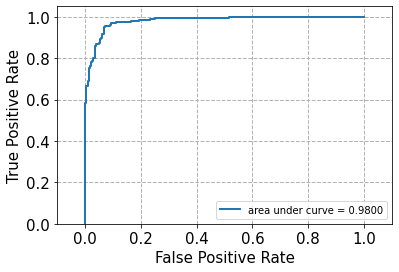

========================= results for 300 dimension =========================
confusion matrix 
 [[240  23]
 [ 15 352]]
accuracy score:  0.9396825396825397
recall score:  0.9396825396825397
precision score:  0.9397144102085279
f1 score:  0.9395419292993417
----------------------------------------


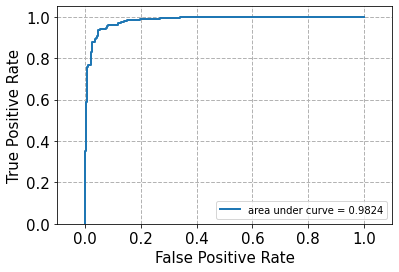

In [ ]:
result_12 = []
for dim in k:
  print("="*25, "results for", dim, "dimension", "="*25)
  accu = get_glove_result_svc(train, test, dim, y_train_binary, y_test_binary)
  result_12.append(accu)

In [ ]:
embeddings_dict = {}
dimension_of_glove = 300
with open("/content/drive/Shareddrives/ECE219_P1/glove.6B.300d.txt", 'r') as f: # if 'r' fails with unicode error, please use 'rb'
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

In [ ]:
# for key, value in embeddings_dict.items():
#   print(key, value)
#   break

# lists_of_keywords = df["keywords"].values.tolist()
# for i in range (5):
#   print(lists_of_keywords[i].split(","))
#   print(len(lists_of_keywords[i].split(",")))
#   print("="*40)



In [ ]:
# df_keywords = train['keywords']
# keywords_list = []
# for i in range(len(df_keywords)):
#   curr_key_words_list = df_keywords.iloc[i]
#   curr_list = curr_key_words_list.replace('\'', '')
#   curr_list = curr_list.replace('[', '')
#   curr_list = curr_list.replace(']', '')
#   curr_list = curr_list.split(', ')
#   keywords_list.append(curr_list)
#   # for word in curr_list:
#   #   print(word)
#   #   if word in embeddings_dict:
#   #     print("Yes")
#   #   else:
#   #     print("No")
#   # print(curr_list)
#   # if (i > 10):
#   #   break

In [ ]:
# test_df_keywords = test['keywords']
# test_keywords_list = []
# for i in range(len(test_df_keywords)):
#   curr_key_words_list = test_df_keywords.iloc[i]
#   curr_list = curr_key_words_list.replace('\'', '')
#   curr_list = curr_list.replace('[', '')
#   curr_list = curr_list.replace(']', '')
#   curr_list = curr_list.split(', ')
#   test_keywords_list.append(curr_list)

In [ ]:

# def get_glove_vector(vocab):
#   global error
#   if(vocab.lower() in (embeddings_dict.keys())):
#     return np.array(embeddings_dict[vocab.lower()])
#   else:
#     #print(vocab)
#     return np.zeros(300)

In [ ]:
# # get_glove_vector("the") + get_glove_vector("the")
# # print(keywords_list)
# train_glove = np.array([])
# for i in range(len(keywords_list)):
#   cur_vec = np.zeros(300)
#   for vocab in keywords_list[i]:
#     cur_vec += get_glove_vector(vocab)
#   if(i == 0):
#     train_glove = np.array([cur_vec])
#   else:
#     train_glove = np.vstack([train_glove, cur_vec])
# # print(train_glove.shape)
# # len(keywords_list)
# error

In [ ]:
# test_glove = np.array([])
# for i in range(len(test_keywords_list)):
#   cur_vec = np.zeros(300)
#   for vocab in test_keywords_list[i]:
#     cur_vec += get_glove_vector(vocab)
#   if(i == 0):
#     test_glove = np.array([cur_vec])
#   else:
#     test_glove = np.vstack([test_glove, cur_vec])

In [ ]:
# # normalization
# normalized_train_glove = normalize(train_glove)
# normalized_test_glove = normalize(test_glove)
# normalized_train_glove

In [ ]:
# glove_svc = LinearSVC(C=1000, random_state=42,max_iter=100000)
# glove_svm_model = glove_svc.fit(normalized_train_glove,y_train_binary)
# glove_y_pred = glove_svm_model.predict(normalized_test_glove)
# get_stats(y_test_binary, glove_y_pred)

# Question 12

Text(0, 0.5, 'SVM accuracy')

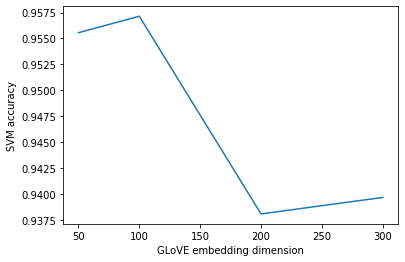

In [ ]:
plt.plot(k, result_12)
plt.xlabel("GLoVE embedding dimension")
plt.ylabel("SVM accuracy")

# Question 13


In [ ]:
!pip install umap-learn
!pip install datashader
!pip install bokeh
!pip install holoviews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import umap
import datashader
import bokeh
import holoviews
import umap.plot

In [ ]:
embedding_dic = choose_dic(300) 

train_glove = create_Glove_vec(train, 300, embedding_dic)
test_glove = create_Glove_vec(test, 300, embedding_dic)
# normalization
normalized_train_glove = normalize(train_glove)
normalized_test_glove = normalize(test_glove)

In [ ]:
normalized_total_glove = np.vstack([normalized_train_glove, normalized_test_glove])
mapper = umap.UMAP().fit(normalized_total_glove)

In [ ]:
random_matrix = np.random.normal(size=(3150, 300))
normalized_random_matrix = normalize(random_matrix)
random_mapper = umap.UMAP().fit(normalized_random_matrix)

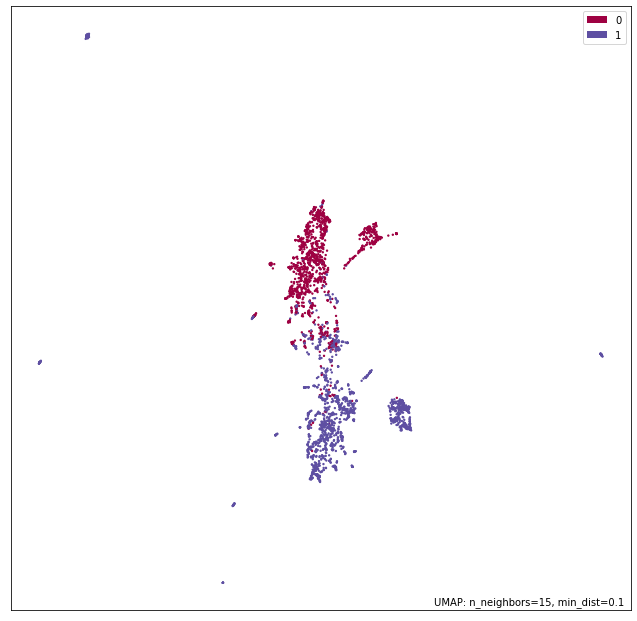

In [ ]:
umap.plot.points(mapper, labels=np.array(y_train_binary + y_test_binary))

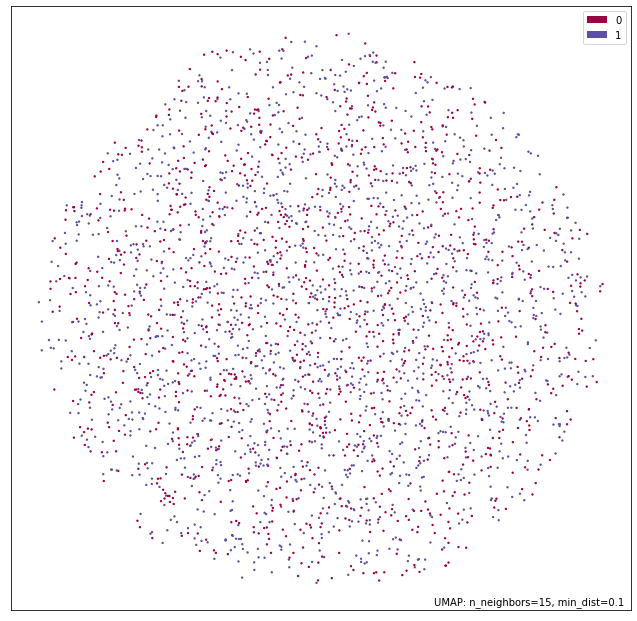

In [ ]:
umap.plot.points(random_mapper, labels=np.array(y_train_binary + y_test_binary)) 

In [ ]:
normalized_train_glove = normalize(train_glove)